In [44]:
import numpy as np
import matplotlib.pyplot as plt

from src.ozone import Ozone

data_path = '/Users/namsonnguyen/repo/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/'
my_ozone = Ozone(am_model_data_path=data_path)

-1.0 1.001 0.04470273766021792 0.211
PWV -> nscale: -1.00
zenith -> airmass: 1.00


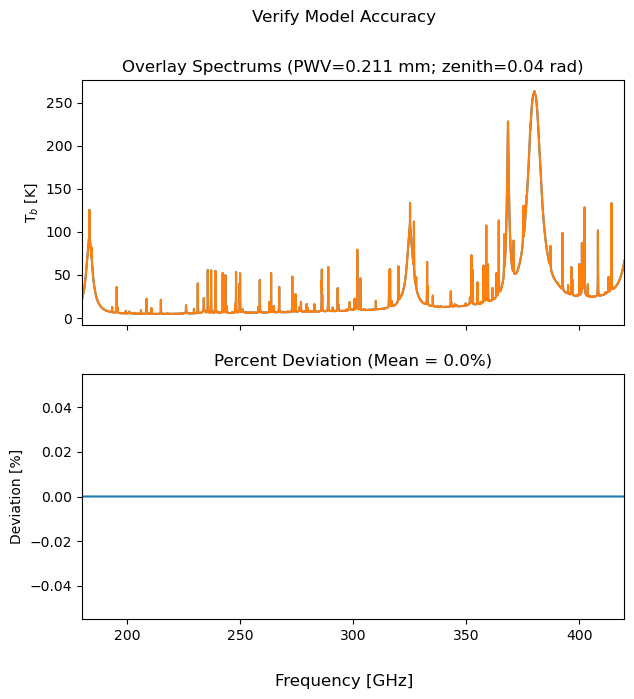

In [86]:
nscale_map = my_ozone.data['Nscale']['map']
airmass_map = my_ozone.data['airmass']['map']
zenith_map = my_ozone._airmass_to_zenith(airmass_map)
nominal_pwv = my_ozone._extract_nominal_pwv()
pwv_map = nominal_pwv * (10**nscale_map)
freq_channels = np.linspace(180, 420, my_ozone.data['freq']['points'])

idx = 0
print(nscale_map[idx], airmass_map[idx], zenith_map[idx], pwv_map[idx])

Tb_data = my_ozone.data['Tb_scalar_field'][idx][idx]
model_spectrum = my_ozone(pwv_map[idx], zenith_map[idx])[0][0]

fig, (ax1, ax2) = plt.subplots(2, 1, sharey=False, sharex=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.2)
fig.supxlabel("Frequency [GHz]")
fig.suptitle("Verify Model Accuracy")

ax1.plot(freq_channels, Tb_data)
ax1.plot(freq_channels, model_spectrum)
ax1.set_title(f"Overlay Spectrums (PWV={pwv_map[idx]} mm; zenith={zenith_map[idx]:.2f} rad)")
ax1.set_ylabel(r'T$_b$ [K]')

comparison = ((model_spectrum - Tb_data) / Tb_data) * 100
ax2.plot(freq_channels, comparison)
ax2.set_title(f"Percent Deviation (Mean = {np.mean(comparison)}%)")
ax2.set_ylabel('Deviation [%]')
ax2.set_xlim(min(freq_channels), max(freq_channels));